In [36]:
require(Seurat)
require(Matrix)
require(ggplot2)
require(ggrepel)
require(enrichR)

In [37]:
data = Read10X(data.dir = "/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/GRCh38")
data = CreateSeuratObject(counts = data, project = "5k", min.cells = 0.1*ncol(data), min.features = 200)

meta = read.table("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', row.names=1, header=T)


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 3082 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3082 rows containing missing values (geom_point).”
Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Warning message:
“Removed 3082 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3082 rows containing missing values (geom_point).”


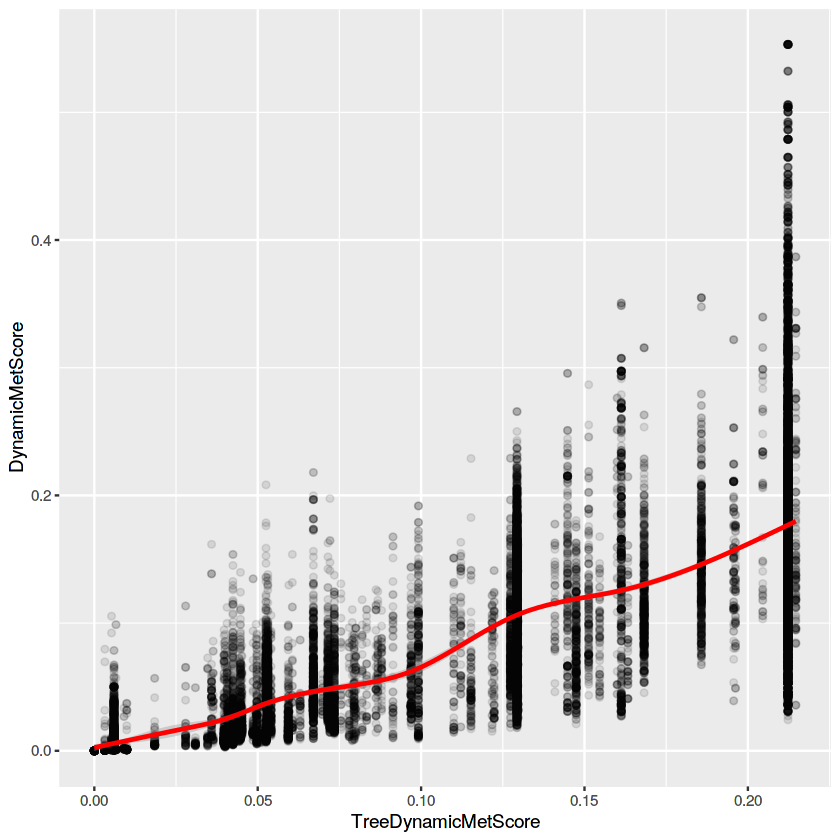

In [38]:
ggplot(meta, aes(TreeDynamicMetScore, DynamicMetScore)) + geom_point(alpha=0.1) + geom_smooth(color = 'red')
ggsave("treemet_score_compare.pdf")

In [39]:
rownames(meta) = unlist(lapply(rownames(meta), function(x) unlist(strsplit(x, "-", fixed=T))[[1]]))

In [40]:
keep.cells = intersect(rownames(meta), colnames(data[['RNA']]@counts))
length(keep.cells)

data = data[,keep.cells]
meta = meta[keep.cells,]


[1] 37814

In [41]:
data$lineage.group = meta[colnames(data), 'LineageGroup']
data$dynamicScore = meta[colnames(data), 'DynamicMetScore']

to.drop = which(is.na(data$dynamicScore))
length(to.drop)
data = data[,-to.drop]

data$dynamicScoreNorm = data$dynamicScore - mean(data$dynamicScore)


[1] 2808

In [42]:
n.factor = median(colSums(data))
data.raw = data

data <- NormalizeData(data, normalization.method = "LogNormalize", scale.factor = n.factor)


In [43]:
bot.perc = 0.004
top.perc = 0.21

# data.met = subset(data.f, ((dynamicScore >= top.perc) | (dynamicScore <= bot.perc)))
data.met = data

data.met$dynamicGroup = unlist(lapply(data.met$dynamicScoreNorm, function(x) return(ifelse(x >= 0, 'High', 'Low'))))

In [44]:
Idents(data.met) = 'dynamicGroup'

In [45]:
de = FindAllMarkers(data.met, test.use='MAST', logfc.threshold=0)

Calculating cluster High

Assuming data assay in position 1, with name et is log-transformed.


 Completed [--------------------------------------------]   0% with 0 failures

 Completed [--------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   1% with 0 failures

 Completed [>-------------------------------------------]   2% with 0 failures

 Completed [>-------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   3% with 0 failures

 Completed [=>------------------------------------------]   4% with 0 failures

 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>---------

In [74]:
compute_log_fc = function(group1, group2) {
    
    fc = mean(group1) / mean(group2)
    return(log2(fc))
    
}

In [91]:
up_cells = colnames(data.met)[data.met$dynamicGroup == "High"]
dwn_cells = colnames(data.met)[data.met$dynamicGroup == "Low"]

head(data.met$dynamicGroup)

LL.AAACCTGCAAGAAAGG LL.AAACCTGGTACATGTC LL.AAACCTGTCAAGGTAA LL.AAACGGGGTCTTGATG 
                 NA              "High"              "High"              "High" 
LL.AAACGGGGTGTTAAGA LL.AAACGGGGTTCGGCAC 
             "High"                  NA

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene,log10_qval
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>
REG4,0,0.4279133,0.399,0.164,0,High,REG4,Inf
IFI27,0,0.4066437,0.444,0.234,0,High,IFI27,Inf
LGALS1,0,0.3795339,0.931,0.800,0,High,LGALS1,Inf
TFF1,0,0.3187683,0.962,0.895,0,High,TFF1,Inf
IFI6,0,0.3089944,0.675,0.450,0,High,IFI6,Inf
PRKCDBP,0,0.3043596,0.728,0.451,0,High,PRKCDBP,Inf


 [1] NA       NA       NA       NA       NA       NA       "SLPI"   "FXYD2" 
 [9] "CFD"    "RPS4Y1" "KRT17"  "ID3"    "IFI6"  


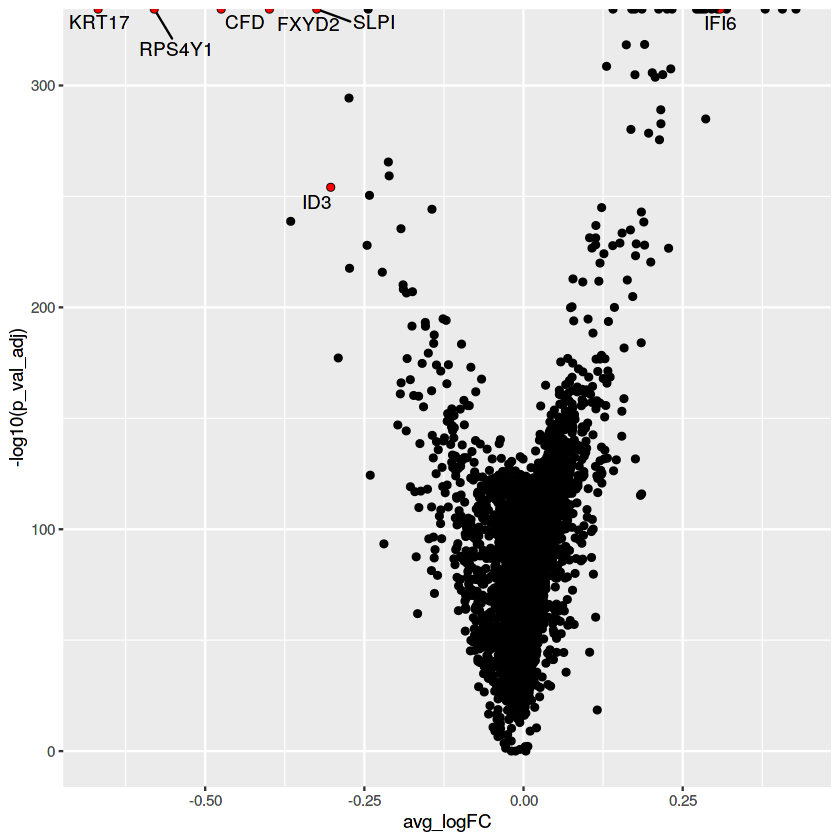

In [46]:
de_high = de[de$cluster == 'High',]
de_low = de[de$cluster == 'Low',]

de_high$log10_qval = -log10(de_high$p_val_adj)
genes = de_high
head(genes)

write.table(de_high, "MAST_de_high.txt", sep='\t')

pos = genes[genes$avg_logFC > 0.30 & genes$log10_qval > -log10(0.05),]
neg = genes[genes$avg_logFC < -0.30 & genes$log10_qval > -log10(0.05),]

pos.quantile = quantile(pos$log10_qval[is.finite(pos$log10_qval)], c(0.6))[[1]]
neg.quantile = quantile(neg$log10_qval[is.finite(neg$log10_qval)], c(0.7))[[1]]

pos.genes = as.character(pos[pos$log10_qval >= pos.quantile,"gene"])
neg.genes = as.character(neg[neg$log10_qval >= neg.quantile,"gene"])

keep.genes = c(pos.genes, neg.genes, 'IFI6')
print(keep.genes)

ggplot(genes, aes(avg_logFC, -log10(p_val_adj), label=gene)) + 
geom_point() + 
geom_text_repel(data = subset(genes, gene %in% keep.genes)) + 
geom_point(color = ifelse(genes$gene %in% keep.genes, "red", "black"), size = ifelse(genes$gene %in% keep.genes, 1, 1/100))


In [87]:
pos = genes[genes$avg_logFC > 0.30 & genes$log10_qval > -log10(0.05),]$gene
neg = genes[genes$avg_logFC < -0.30 & genes$log10_qval > -log10(0.05),]$gene

db= enrichr(pos, databases=c('MSigDB_Oncogenic_Signatures'))$MSigDB_Oncogenic_Signatures
db[order(db$Adjusted.P.value),]

Uploading data to Enrichr... Done.
  Querying MSigDB_Oncogenic_Signatures... Done.
Parsing results... Done.


,Term,Overlap,P.value,Adjusted.P.value,Old.P.value,Old.Adjusted.P.value,Odds.Ratio,Combined.Score,Genes
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
3,LEF1 UP.V1 UP,4/195,1.968842e-04,0.01240371,0,0,13.675214,116.689159,LGALS1;PRKCDBP;FN1;S100A4
1,BMI1 DN MEL18 DN.V1 DN,4/147,6.616028e-05,0.01250429,0,0,18.140590,174.574699,IFI27;IFI6;S100A4;NEAT1
2,LEF1 UP.V1 DN,4/190,1.782334e-04,0.01684306,0,0,14.035088,121.156723,DPYSL3;AGR2;TFF1;CXCL5
6,ALK DN.V1 DN,3/148,1.392368e-03,0.04385960,0,0,13.513514,88.874988,IFI27;CEACAM6;IFI6
5,BMI1 DN.V1 DN,3/144,1.286950e-03,0.04864670,0,0,13.888889,92.437228,IFI27;IFI6;S100A4
4,RB P130 DN.V1 DN,3/139,1.162465e-03,0.05492649,0,0,14.388489,97.226075,NEAT1;CLU;B2M
10,MEK UP.V1 UP,3/196,3.096721e-03,0.05852802,0,0,10.204082,58.953179,ALDH3A1;AKR1B10;CEACAM6
9,LTE2 UP.V1 DN,3/196,3.096721e-03,0.06503113,0,0,10.204082,58.953179,LGALS1;IFI27;IFI6
8,P53 DN.V1 UP,3/194,3.008464e-03,0.07107495,0,0,10.309278,59.859028,IFI27;CEACAM6;AGR2
